# Load e imports

In [135]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h2o

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

In [136]:
df = pd.read_csv('data_balanced.csv', encoding='utf-8')

# Avaliando modelo por liga

## Preprocessamento

In [137]:
# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
        ],
        remainder='passthrough'  # Mantém as características categóricas sem transformação
    )
    return preprocessor.fit(X)

## Treinamento

In [138]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline

# Lista das ligas únicas no conjunto de dados
leagues = df['league'].unique()

# Dicionário para armazenar histórico de treinamento e avaliação para cada liga
league_histories = {}

# Loop por cada liga para criar, treinar e avaliar um modelo separado
for league in leagues:
    print(f"Treinando modelo para a liga: {league}")
    
    # Filtrando o conjunto de dados para apenas a liga atual
    league_data = df[df['league'] == league]
    
    # Preparando os dados de entrada e saída
    X = league_data.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
    # X = league_data.drop(['result', 'league'], axis=1)
    y = league_data['result']

    preprocessor = create_preprocessor(X)
    X_transformed = preprocessor.transform(X)

    
    model_randomf = RandomForestClassifier(n_estimators=100, random_state=42, 
                                           max_depth=10, min_samples_split=5, 
                                            min_samples_leaf=2)

    # model_randomf = RandomForestClassifier(n_estimators=200)
    
    # Validação cruzada
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='roc_auc')
    print(f"Média AUC para {league}: {cv_scores.mean()}")

    # acuracia
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='accuracy')
    print(f"Média Acurácia para {league}: {cv_scores.mean()}")

    # Treinando e avaliando o modelo
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model_randomf.fit(X_train, y_train)
    train_auc = roc_auc_score(y_train, model_randomf.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, model_randomf.predict_proba(X_test)[:, 1])

    feature_importance = model_randomf.feature_importances_

    # Armazenando a avaliação em um dicionário
    league_histories[league] = {
        'cv_auc_mean': cv_scores.mean(),
        'train_auc': train_auc,
        'test_auc': test_auc,
        'feature_importance': feature_importance
    }

Treinando modelo para a liga: South America - Copa Libertadores
Média AUC para South America - Copa Libertadores: 0.9811820730847822
Média Acurácia para South America - Copa Libertadores: 0.9268865409301867
Treinando modelo para a liga: Asia - AFC Champions League
Média AUC para Asia - AFC Champions League: 0.9819488829224932
Média Acurácia para Asia - AFC Champions League: 0.9414574085982717
Treinando modelo para a liga: Brazil - Paulista A1
Média AUC para Brazil - Paulista A1: 0.9863391003460208
Média Acurácia para Brazil - Paulista A1: 0.9572549019607843
Treinando modelo para a liga: South America - Copa Sudamericana
Média AUC para South America - Copa Sudamericana: 0.9837081298477448
Média Acurácia para South America - Copa Sudamericana: 0.9461016949152542
Treinando modelo para a liga: Japan - J-League
Média AUC para Japan - J-League: 0.9792782074945949
Média Acurácia para Japan - J-League: 0.9363817097415505
Treinando modelo para a liga: USA - Major League Soccer
Média AUC para US

## Avaliando importancia das features de cada liga

In [139]:
# # Suponha que X_train tenha os nomes das features e league_histories contenha as importâncias
# feature_names = X.columns

# # Loop para criar um gráfico para cada liga
# for league, data in league_histories.items():
#     # Ordenar as características e suas importâncias
#     sorted_idx = np.argsort(data['feature_importance'])
#     sorted_feature_names = feature_names[sorted_idx]
#     sorted_importances = data['feature_importance'][sorted_idx]

#     # Criando o gráfico
#     plt.figure(figsize=(10, 8))
#     plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
#     plt.title(f'Feature Importance for {league}')
#     plt.xlabel('Importance')
#     plt.ylabel('Features')
#     plt.show()


In [140]:
dataframe_league = pd.DataFrame.from_dict(league_histories, orient='index')
# dataframe_league.to_csv('dataframe_leagues_avaliation_before_f_engineering.csv', index=False, encoding='utf-8')
dataframe_league

,cv_auc_mean,train_auc,test_auc,feature_importance
South America - Copa Libertadores,0.926887,0.996205,0.979823,"[0.30284782014928724, 0.08413149937237796, 0.0..."
Asia - AFC Champions League,0.941457,0.996766,0.979669,"[0.2929598676871346, 0.06555801618961198, 0.07..."
Brazil - Paulista A1,0.957255,0.998654,0.978292,"[0.2950144373111903, 0.07134526742931062, 0.05..."
South America - Copa Sudamericana,0.946102,0.997037,0.971438,"[0.31030975708718816, 0.06882753049040947, 0.0..."
Japan - J-League,0.936382,0.995170,0.977247,"[0.29767446207742215, 0.08896310044393259, 0.0..."
USA - Major League Soccer,0.891537,0.985536,0.959985,"[0.30179147690348107, 0.07772864536307235, 0.0..."
Mexico - Liga MX,0.931301,0.993054,0.975997,"[0.26250721992699894, 0.05812785124147445, 0.0..."
Scotland - Premiership,0.946773,0.998083,0.988968,"[0.2767038434179758, 0.04433232356517339, 0.05..."
Brazil - Serie A,0.931457,0.994902,0.985667,"[0.3131060547882968, 0.06634991926385843, 0.07..."
France - Ligue 1,0.948391,0.997553,0.988412,"[0.2518410740102216, 0.05602906859008287, 0.04..."


In [141]:
# We calculate the mean importance for each feature across all leagues
mean_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist()).mean().tolist()

# First, let's convert the list of feature importances into a DataFrame for easier analysis
df_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist())

# Calculating the variance of each feature's importance across all leagues
feature_variances = df_feature_importances.var()

# Creating a summary DataFrame to hold the variance and correlation data
summary_df = pd.DataFrame({
    'Mean Importance': mean_feature_importances,
    'Variance': feature_variances,
})

# Display the summary dataframe sorted by variance to see which features have the most variability across leagues
summary_df.sort_values('Variance', ascending=False, inplace=True)
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Feature'}, inplace=True)

feature_names = df.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1).columns
# feature_names = df.drop(['result', 'league'], axis=1).columns

# Mapeando os números para os nomes das características
summary_df['Feature Name'] = summary_df['Feature'].apply(lambda x: feature_names[x])

summary_df.sort_values('Mean Importance', ascending=False)

,Feature,Mean Importance,Variance,Feature Name
0,0,0.283625,8.229042e-04,minute
2,20,0.072081,1.809008e-04,tackles_away
4,16,0.065603,1.500438e-04,fouls_away
3,1,0.064380,1.744448e-04,shotsHome
5,19,0.063828,1.402506e-04,tackles_home
6,15,0.059327,7.786218e-05,fouls_home
1,2,0.055210,1.823479e-04,shotsAway
7,11,0.037840,6.421984e-05,shotsOngoal_home
12,22,0.036834,3.290829e-05,possessiontime_home
11,21,0.036796,3.536600e-05,possessiontime_away


- Importância das Características: A tabela fornece um valor de importância média para cada característica, que indica quanto essa característica contribui para a capacidade do modelo de fazer previsões. Quanto maior o valor, mais importante é a característica.

- Variância da Importância: A variância pode nos dizer quão consistente é a importância de uma característica entre os diferentes modelos de liga. Uma variância baixa significa que a característica tem aproximadamente a mesma importância em todas as ligas, enquanto uma variância alta sugere que a importância da característica varia significativamente entre as diferentes ligas.

- Diferenças entre as Ligas: Se algumas características têm uma alta variância na importância, isso pode indicar que as ligas têm dinâmicas diferentes que afetam os resultados dos jogos. Por exemplo, uma característica pode ser muito importante em uma liga, mas menos importante em outra.

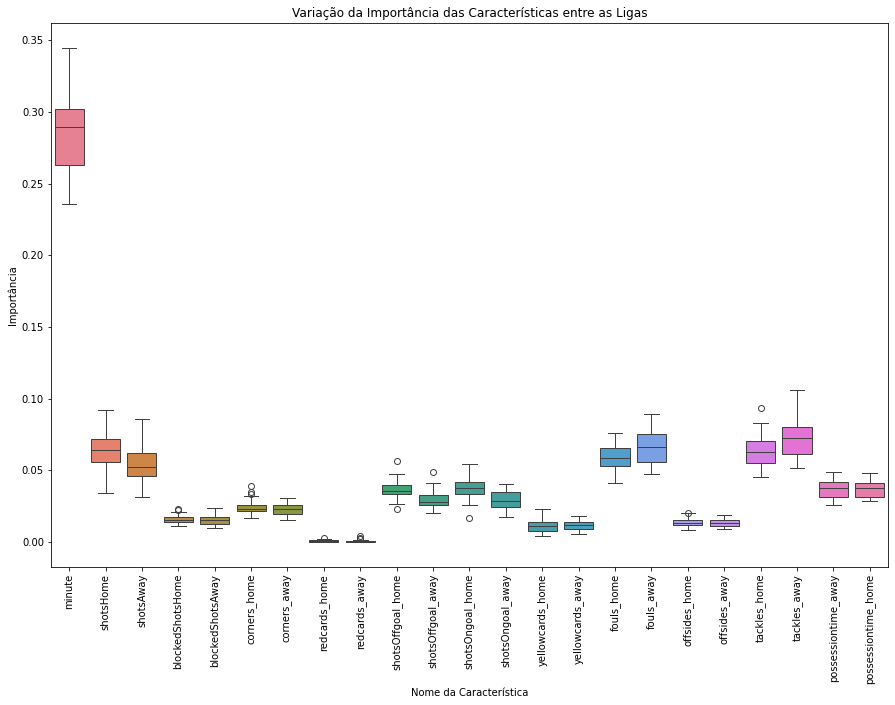

In [142]:
def convert_to_list(ndarray):
    # Verifica se o ndarray não é vazio e converte para lista
    return ndarray.tolist() if ndarray.size else []

importance_lists = dataframe_league['feature_importance'].apply(convert_to_list)

# Criando um DataFrame para armazenar os valores de importância para todas as ligas
feature_importance_df = pd.DataFrame(importance_lists.tolist())

# Calculando estatísticas descritivas para cada característica em todas as ligas
feature_importance_stats = feature_importance_df.describe()

# feature_names = summary_df['Feature Name'].tolist()

# Criar o gráfico de boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=feature_importance_df)
ax.set_title('Variação da Importância das Características entre as Ligas')
ax.set_xlabel('Nome da Característica')
ax.set_ylabel('Importância')
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90)
plt.show()


- Variação na Importância: Características com boxplots mais largos indicam uma maior variação na sua importância entre as ligas. Isso sugere que o impacto dessas características é mais específico para cada liga. Por outro lado, características com boxplots mais estreitos mostram uma consistência maior, indicando que a importância dessas características é mais uniforme entre as ligas.
Outliers:

- Alguns boxplots têm pontos outliers, que representam ligas onde a importância da característica é notavelmente diferente do padrão observado na maioria das outras ligas. Esses outliers podem indicar casos específicos onde uma característica é particularmente mais ou menos relevante.

- Modelos Personalizados para Ligas: As características com maior variação (boxplots mais largos e/ou com outliers) são fortes candidatas a justificar a criação de modelos separados para cada liga. Isso permitiria que os modelos levassem em conta as peculiaridades de cada liga, resultando em previsões mais precisas.

- Características com menor variação podem ser tratadas de forma mais consistente entre os modelos para diferentes ligas.

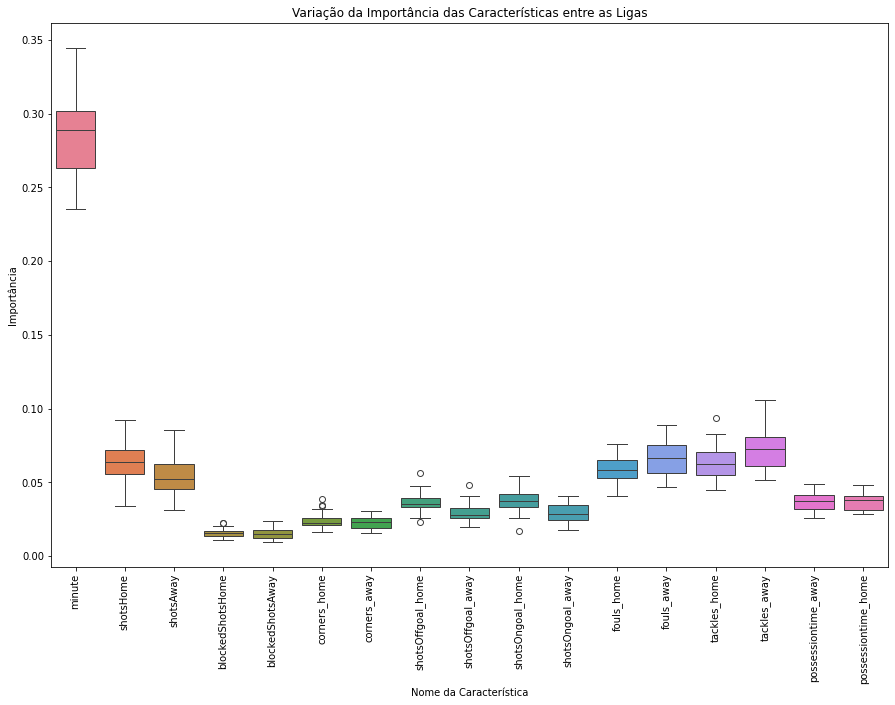

In [148]:
low_importance_features_indices = summary_df[summary_df['Mean Importance'] <= 0.013664]['Feature'].tolist()
# low_importance_features_indices2 = summary_df[summary_df['Variance'] >= 0.000016]['Feature'].tolist()
# low_importance_features_indices = low_importance_features_indices1 + low_importance_features_indices2

feature_importance_df_filtered = feature_importance_df.drop(columns=low_importance_features_indices, axis=1)

feature_names_filtered = [feature_names[i] for i in range(len(feature_names)) if i not in low_importance_features_indices]

# Criar o gráfico de boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=feature_importance_df_filtered)
ax.set_title('Variação da Importância das Características entre as Ligas')
ax.set_xlabel('Nome da Característica')
ax.set_ylabel('Importância')
plt.xticks(ticks=np.arange(len(feature_names_filtered)), labels=feature_names_filtered, rotation=90)
plt.show()


# Engenharia de recursos

In [150]:
df = pd.read_csv('data_balanced.csv', encoding='utf-8')

In [151]:
# ao invés de excluir a característica, vamos criar uma baseada nela juntamente com outra característica
df['total_cards'] = df['yellowcards_home'] + df['yellowcards_away'] + df['redcards_home'] + df['redcards_away']

# Agressividade ao longo do tempo: combinando faltas e cartões amarelos com minutos
df['aggressiveness_over_time_home'] = (df['fouls_home'] + df['yellowcards_home']) * df['minute'].round(2)
df['aggressiveness_over_time_away'] = (df['fouls_away'] + df['yellowcards_away']) * df['minute'].round(2)

# agora posso excluir características com baixa importância
low_importance_features = summary_df[summary_df['Mean Importance'] <= 0.013664]['Feature Name'].tolist()
print("Características com baixa importância:\n", low_importance_features)

# Removendo as características com baixa importância
df.drop(columns=low_importance_features, inplace=True)

Características com baixa importância:
 ['yellowcards_home', 'yellowcards_away', 'offsides_home', 'offsides_away', 'redcards_away', 'redcards_home']


In [152]:
# Eficiência defensiva: razão entre desarmes e chutes ao gol do adversário
df['defensive_efficiency_home'] = (df['tackles_home'] / (df['shotsOngoal_away'] + 1)).round(2)  # +1 para evitar divisão por zero
df['defensive_efficiency_away'] = (df['tackles_away'] / (df['shotsOngoal_home'] + 1)).round(2)  # +1 para evitar divisão por zero

# Eficiência de posse de bola: razão entre tempo de posse e chutes ao gol
df['possession_efficiency_home'] = df['possessiontime_home'] / (df['shotsOngoal_home'] + 1).round(2)
df['possession_efficiency_away'] = df['possessiontime_away'] / (df['shotsOngoal_away'] + 1).round(2)

# Estabilidade defensiva: combinação entre desarmes e menor número de faltas
df['defensive_stability_home'] = (df['tackles_home'] / (df['fouls_home'] + 1)).round(2)
df['defensive_stability_away'] = (df['tackles_away'] / (df['fouls_away'] + 1)).round(2)

# caracteristicas relacionadas ao tempo
# Pressão ao longo do tempo: incorporando chutes ao gol e posse de bola ao longo dos minutos
df['pressure_over_time_home'] = ((df['shotsOngoal_home'] + df['possessiontime_home']) * df['minute']).round(2)
df['pressure_over_time_away'] = ((df['shotsOngoal_away'] + df['possessiontime_away']) * df['minute']).round(2)

# Intensidade de ataque: razão entre chutes ao gol e minutos    
df['attack_intensity_home'] = (df['shotsOngoal_home'] / df['minute']).round(2)
df['attack_intensity_away'] = (df['shotsOngoal_away'] / df['minute']).round(2)

# Progresso da posse de bola: incorporando tempo de posse e minutos
df['possession_progress_home'] = (df['possessiontime_home'] * df['minute']).round(2)
df['possession_progress_away'] = (df['possessiontime_away'] * df['minute']).round(2)

# Performace defensiva: razão entre desarmes e minutos
df['defensive_performance_home'] = (df['tackles_home'] / df['minute']).round(2)
df['defensive_performance_away'] = (df['tackles_away'] / df['minute']).round(2)

# Eficiência de progresso do jogo: incorporando eficiência de posse de bola e minutos
df['game_progress_efficiency_home'] = (df['possession_efficiency_home'] * df['minute']).round(2)
df['game_progress_efficiency_away'] = (df['possession_efficiency_away'] * df['minute']).round(2)

# Momentum do jogo: incorporando chutes ao gol, posse de bola e minutos
df['game_momentum_home'] = ((df['shotsOngoal_home'] + df['possessiontime_home']) / (90 - df['minute'] +1)).round(2)
df['game_momentum_away'] = ((df['shotsOngoal_away'] + df['possessiontime_away']) / (90 - df['minute'] +1)).round(2)

# Total de faltas por jogo
df['total_fouls'] = df['fouls_home'] + df['fouls_away']

# Verificamos se as novas colunas foram adicionadas corretamente
new_features_head = df[['defensive_efficiency_home','defensive_efficiency_home',
                        'aggressiveness_over_time_home', 'aggressiveness_over_time_away',
                        'possession_efficiency_home', 'possession_efficiency_away',
                        'total_fouls','defensive_stability_home', 
                        'defensive_stability_away', 'pressure_over_time_home', 
                        'total_cards', 'pressure_over_time_away',
                        'attack_intensity_home', 'attack_intensity_away',
                        'possession_progress_home', 'possession_progress_away',
                        'defensive_performance_home', 'defensive_performance_away',
                        'game_progress_efficiency_home', 'game_progress_efficiency_away',
                        'game_momentum_home', 'game_momentum_away']].head()

new_features_head


,defensive_efficiency_home,defensive_efficiency_home,aggressiveness_over_time_home,aggressiveness_over_time_away,possession_efficiency_home,possession_efficiency_away,total_fouls,defensive_stability_home,defensive_stability_away,pressure_over_time_home,...,attack_intensity_home,attack_intensity_away,possession_progress_home,possession_progress_away,defensive_performance_home,defensive_performance_away,game_progress_efficiency_home,game_progress_efficiency_away,game_momentum_home,game_momentum_away
0,4.00,4.00,74.0,111.0,23.333333,15.0,4.0,4.00,1.75,2664.0,...,0.05,0.03,2590.0,1110.0,0.22,0.19,863.33,555.0,1.33,0.57
1,1.75,1.75,330.0,264.0,64.000000,9.0,16.0,0.70,1.00,2112.0,...,0.00,0.09,2112.0,1188.0,0.21,0.24,2112.00,297.0,1.10,0.67
2,5.00,5.00,252.0,180.0,31.000000,38.0,10.0,0.62,1.00,2268.0,...,0.03,0.00,2232.0,1368.0,0.14,0.11,1116.00,1368.0,1.15,0.69
3,1.00,1.00,168.0,252.0,12.250000,51.0,8.0,0.33,1.71,2184.0,...,0.07,0.00,2058.0,2142.0,0.02,0.29,514.50,2142.0,1.06,1.04
4,3.50,3.50,310.0,155.0,14.666667,28.0,13.0,0.70,1.00,1426.0,...,0.06,0.03,1364.0,1736.0,0.23,0.16,454.67,868.0,0.77,0.95


- Eficiência Defensiva: A eficiência defensiva é uma boa medida para avaliar como uma equipe evita que o adversário marque gols. Ela combina a habilidade defensiva (desarmes) com a pressão do adversário (chutes ao gol).

- Agressividade ao Longo do Tempo: Esta característica captura como a agressividade da equipe (faltas e cartões amarelos) se desenvolve ao longo do jogo. Isso pode ser útil para entender como a disciplina da equipe ou a pressão do jogo influencia seu comportamento.

- Eficiência de Posse de Bola: Esta medida reflete quão efetivamente uma equipe usa seu tempo de posse para criar oportunidades de gol (chutes ao gol). Uma posse de bola alta sem chutes ao gol pode indicar uma eficiência baixa.

- Total de Cartões por Jogo: A soma dos cartões amarelos e vermelhos pode ser um indicador da disciplina da equipe e da severidade das faltas cometidas.

- Total de Faltas por Jogo: Semelhante ao total de cartões, o total de faltas pode indicar a agressividade da equipe e sua tendência a interromper o jogo adversário.

- Intensidade de Ataque por Intervalo de Tempo: Podemos calcular a intensidade do ataque em diferentes intervalos do jogo, como chutes ao gol por minuto.

- Evolução da Posse de Bola: Esta característica poderia refletir como a posse de bola se desenvolve ao longo do tempo, talvez indicando o controle do jogo.

- Desempenho Defensivo ao Longo do Tempo: Similar à intensidade do ataque, mas focado na defesa. Quantos desarmes foram feitos por minuto

- Eficiência ao Longo do Jogo: Avaliar a eficiência da equipe ao longo do tempo pode ser útil, combinando posse de bola e chutes ao gol com o decorrer do tempo.

- Momentum de Jogo: A ideia aqui é capturar se uma equipe está ganhando momentum ao longo do jogo, indicado por uma combinação de posse de bola e chutes ao gol em relação ao tempo decorrido.

In [153]:
# Verificar a presença de valores infinitos
# print(df.replace([np.inf, -np.inf], np.nan).isnull().sum())

# # Substituir infinitos por NaN e então por um valor numérico ou excluir essas linhas
# df.replace([np.inf, -np.inf], np.nan, inplace=True)

# # substituído pelo último valor não-NaN anterior na coluna.
# df.fillna(method='ffill', inplace=True)

In [154]:
df.to_csv("data_live_engineer.csv", index=False, encoding="utf-8")